In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import display 
import data_utils
import model_utils
import keras_metrics
import keras.backend as K

# Pretty display for notebooks
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
dataset = pd.read_csv("datasets/dataset.csv")
display(dataset.head(n = 5))

labels = dataset[['RIESGO_VIDA']]
features = dataset.drop(['RIESGO_VIDA'], axis = 1)

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,AFEC_DPTO,AFEC_EDADR,AFEC_EDUC,AFEC_GENERO,AFEC_GETNICO,AFEC_MPIO,AFEC_PARENTESCO,AFEC_POBESPECIAL,AFEC_REGAFILIACION,AFEC_TIPOPER,...,PATOLOGIA_TIPO,PET_COD_DEPTO,PET_MPIO,PET_TIPOPER,PQR_CANAL,PQR_CLASE_SNS,PQR_TIPOATENCION,PQR_TIPOPETICION,TRIM,RIESGO_VIDA
0,7.092092e-01,1.486486e-01,4.364364e-01,3.398398e-01,6.256256e-01,0.444945,7.192192e-01,5.950951e-01,4.504505e-01,9.999999e-01,...,4.879880e-01,0.277778,2.702703e-01,1.0,0.260761,9.999999e-01,0.222222,5.915916e-01,3.573574e-01,1
1,8.478478e-01,9.999999e-01,9.704705e-01,9.999999e-01,6.256256e-01,0.800801,3.798799e-01,5.950951e-01,9.999999e-01,9.999999e-01,...,4.879880e-01,0.744244,8.288288e-01,1.0,1.000000,9.999999e-01,1.000000,5.915916e-01,1.000000e-07,1
2,3.748749e-01,4.019019e-01,1.000000e-07,9.999999e-01,6.256256e-01,0.370370,9.199199e-01,5.950951e-01,4.504505e-01,9.999999e-01,...,4.879880e-01,0.524024,3.978979e-01,1.0,0.625626,9.999999e-01,1.000000,5.915916e-01,6.381381e-01,0
3,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.054054,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,...,1.000000e-07,0.277778,1.239743e-07,1.0,0.625626,1.000000e-07,1.000000,1.000000e-07,6.381381e-01,0
4,6.206206e-01,9.999999e-01,9.094094e-01,3.398398e-01,6.256256e-01,0.594094,9.199199e-01,5.950951e-01,4.504505e-01,9.999999e-01,...,4.879880e-01,0.265265,4.914915e-01,1.0,1.000000,9.999999e-01,1.000000,9.999999e-01,6.381381e-01,0


In [2]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(features.values, labels.values, test_size=0.2, random_state=1)


from numpy import array

X_train = np.asarray(list(map(lambda row: row.reshape(7,5,1), X_train)))
X_test = np.asarray(list(map(lambda row: row.reshape(7,5,1), X_test)))

display(X_train.shape)
display(X_test.shape)

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


display(y_train.shape)
display(y_test.shape)


(1071324, 7, 5, 1)

(267831, 7, 5, 1)

(1071324, 2)

(267831, 2)

## Treating features as spatial features

In [3]:
#Taking a samples from the two categories (1 and 0)
mX_train = np.asarray(list(map(lambda row: row.reshape(7,5), features.values)))
mY_train = to_categorical(labels, 2)

images_0 = data_utils.getSample(mX_train, mY_train, 0, 20)
images_1 = data_utils.getSample(mX_train, mY_train, 1, 20)

### Sample for records with label = 0

In [4]:
def scale_number(x, xMin, xMax, a, b):
    return ((x - xMin) / (xMax - xMin))*(b - a) + a

def plotFeatures(images, columns):
    plt.figure(figsize=(20,10))
    average = []
    for i, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        average.append(np.average(image))

    print("Average gray scale: %f"%(scale_number(np.average(average), 0, 1, 0, 255)))

### Sample for records with label = 0

Average gray scale: 120.893814


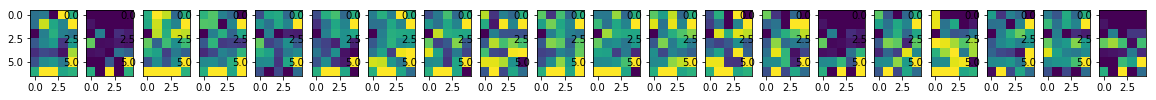

In [5]:
plotFeatures(images_0, 20)

### Sample for records with label = 1

Average gray scale: 161.180501


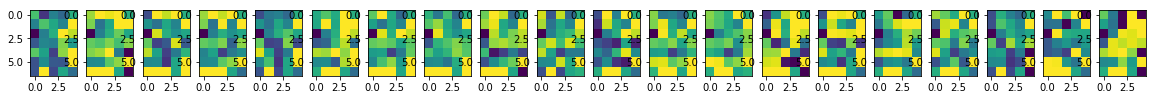

In [6]:
plotFeatures(images_1, 20)

Transforming the features as 2 dimensional images (with no rgb dimensions) reveals a new patern: Records representing patients with life at risk show predominat higher overal values, which is represented as lighter average color per image.

### Compile the Model

In [32]:
from keras.layers import Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras_metrics import *

def create_model():
    model = Sequential()
    ### Architecture
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(7, 5, 1)))
    model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='sigmoid'))
    model.summary()
  
    ### Model building
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=[f1_score()])
 
    return model


In [33]:
from keras.wrappers.scikit_learn import KerasClassifier

checkpointer = ModelCheckpoint(filepath='weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
#sk_params = {'callbacks': [checkpointer]}

#model = KerasClassifier(build_fn=create_model, epochs=3, batch_size=1000, verbose=1)

echocs = 3
batch_size = 1000
model = create_model()
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=100, batch_size=10000, callbacks=[checkpointer], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 7, 5, 16)          80        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 5, 16)          1040      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 2, 16)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 2, 32)          2080      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 2, 32)          4128      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_11  (None, 32)                0         
__________

1071324/1071324 [==============================] - 22s 21us/step - loss: 0.2492 - f1_score: 0.7223 - val_loss: 0.2495 - val_f1_score: 0.7109

Epoch 00029: val_loss improved from 0.25141 to 0.24950, saving model to weights.best.from_scratch.hdf5
Epoch 30/100
1071324/1071324 [==============================] - 23s 21us/step - loss: 0.2484 - f1_score: 0.7236 - val_loss: 0.2520 - val_f1_score: 0.7320

Epoch 00030: val_loss did not improve from 0.24950
Epoch 31/100
1071324/1071324 [==============================] - 26s 24us/step - loss: 0.2479 - f1_score: 0.7245 - val_loss: 0.2534 - val_f1_score: 0.7401

Epoch 00031: val_loss did not improve from 0.24950
Epoch 32/100
1071324/1071324 [==============================] - 22s 21us/step - loss: 0.2471 - f1_score: 0.7257 - val_loss: 0.2463 - val_f1_score: 0.7229

Epoch 00032: val_loss improved from 0.24950 to 0.24626, saving model to weights.best.from_scratch.hdf5
Epoch 33/100
1071324/1071324 [==============================] - 22s 21us/step - loss:

1071324/1071324 [==============================] - 29s 27us/step - loss: 0.2359 - f1_score: 0.7441 - val_loss: 0.2369 - val_f1_score: 0.7381

Epoch 00066: val_loss improved from 0.23791 to 0.23693, saving model to weights.best.from_scratch.hdf5
Epoch 67/100
1071324/1071324 [==============================] - 29s 27us/step - loss: 0.2359 - f1_score: 0.7439 - val_loss: 0.2365 - val_f1_score: 0.7393

Epoch 00067: val_loss improved from 0.23693 to 0.23651, saving model to weights.best.from_scratch.hdf5
Epoch 68/100
1071324/1071324 [==============================] - 29s 27us/step - loss: 0.2356 - f1_score: 0.7438 - val_loss: 0.2367 - val_f1_score: 0.7480

Epoch 00068: val_loss did not improve from 0.23651
Epoch 69/100
1071324/1071324 [==============================] - 29s 27us/step - loss: 0.2352 - f1_score: 0.7445 - val_loss: 0.2364 - val_f1_score: 0.7456

Epoch 00069: val_loss improved from 0.23651 to 0.23638, saving model to weights.best.from_scratch.hdf5
Epoch 70/100
1071324/1071324 [===

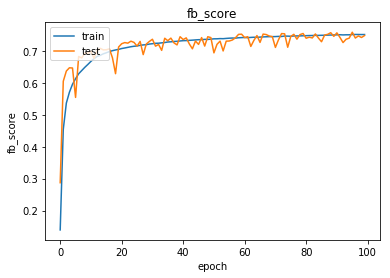

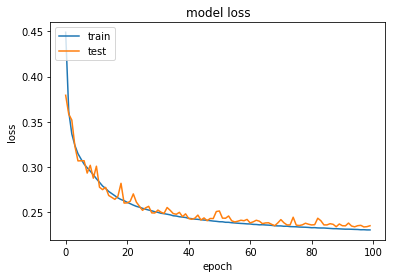

In [29]:
import matplotlib.pyplot as plt
import numpy

# summarize history for accuracy
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('fb_score')
plt.ylabel('fb_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model Validation
## Evaluating unseen data from original dataset

In [ ]:
'''
from sklearn.model_selection import KFold
display(y_val.shape)
evaluate = model.evaluate(X_val, to_categorical(y_val, 2))
print(model.metrics_names)
print(evaluate)
'''

## Evaluating unseen data from validation dataset

In [34]:

dataset_validation = pd.read_csv("datasets/dataset_validation.csv")

labels_validation = dataset_validation[['RIESGO_VIDA']].values
features_validation = dataset_validation.drop(['RIESGO_VIDA'], axis = 1).values

X_validation = np.asarray(list(map(lambda row: row.reshape(7,5,1), features_validation)))
y_validation = to_categorical(labels_validation, 2)

evaluate = model.evaluate(X_validation, y_validation)
print(model.metrics_names)
print(evaluate)


70482/70482 [==============================] - 3s 45us/step
['loss', 'f1_score']
[0.2360127115429931, 0.7329674677523487]


tn: 54678.000000, fp: 1913.000000, fn:4752.000000, tp: 9139.000000


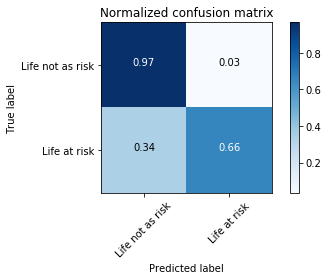

In [41]:

from sklearn.metrics import confusion_matrix
'''
y_pred = model.predict_classes(X_val)
cnf_matrix = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = confusion_matrix(y_val.flatten(), y_pred).ravel()
print("tn: %f, fp: %f, fn:%f, tp: %f"%(tn, fp, fn, tp))
recall_value = float(tp)/(tp+fn)
loss_value = float(fn)/tp
print("recall = %f"%(recall_value))
print("loss = %f"%(loss_value))
print("total = %f"%(loss_value + recall_value))
'''

y_predictions = model.predict(X_validation)
y_predictions = np.argmax(y_predictions, axis = 1)
y_validation_2 = np.argmax(y_validation, axis = 1)

cnf_matrix = confusion_matrix(y_validation_2, y_predictions.flatten())
tn, fp, fn, tp = confusion_matrix(y_validation_2, y_predictions).ravel()
print("tn: %f, fp: %f, fn:%f, tp: %f"%(tn, fp, fn, tp))
model_utils.plot_confusion_matrix(cnf_matrix, classes=['Life not as risk', 'Life at risk'], normalize = True)
